# Problem 1

In [2]:
import numpy as np
import matplotlib.pyplot as pl
from scipy.spatial import KDTree
import time

In [3]:
rng = np.random.default_rng(66727)

In [6]:
def gen_catalog(n, size=100, dims=3, rng=rng):
    '''
    Generate a catlog of 'n' points in 'dims' dimensions distributed uniformly at random

    n: number of samples
    size: side length of cubical box
    dims: dimensions of cube
    rng: numpy random number generator object
    '''
    return rng.random((n,dims))*size


def sq_dist(x1,x2):
    '''
    Convenience function for squared distances
    '''
    return np.sum((x1-x2)**2)

def dist(x1, x2):
    '''
    Convenience function for distances
    '''
    return sq_dist(x1,x2)**0.5

def sep(x1,x2):
    '''
    Convenience function for seperation vectors
    '''
    return (x1-x2) / dist(x1,x2)

def soft_grav(x1, x2, m = 1, eta = 1):
    '''
    Softened gravity implementation

    Parameters
    ----------
    x1,x2: object coordinates
    m = mass of x2 (if we want the acceleration on x1)
    eta = softening factor
    '''
    return -m / (sq_dist(x1,x2) + eta**2) * sep(x1,x2)

def brute_acc(cat, f, eta=1):
    '''
    Brute force n-body acceleration function

    Parameters
    ----------
    cat: catalog of object coordinates
    f: acceleration function
    eta: softening factor

    Returns
    --------
    nxd array of acceleration on all n particles in all d dimensions
    '''
    acc = np.zeros(cat.shape)

    #double loop to consider force of every particle on every other
    for i in range(len(cat)):
        for j in range(len(cat)):
            if i<=j:
                continue
            a = f(cat[i], cat[j], eta=eta)

            #Newton's third law says we don't have to revisit this pairing in reverse
            acc[i] += a
            acc[j] -= a
    
    return acc


def coms(node, cat, dic, node_idx=0):
    '''
    Convenience function for getting the center of mass for every node in a scipy KDTree

    Parameters
    ----------
    node: scipy node object within KDTree
    cat: catalog of n points partitioned by the KDTree
    dic: dictionary to store com values
    node_idx: label for the com dictionary

    Returns
    --------
    Populates the dic dictionary with com values for every node in the tree
    '''

    if isinstance(node, KDTree.leafnode):
        com = np.average(cat[node.idx], axis=0)
        dic[node_idx] = com

    # recursively navigate the tree
    # if leaf node then compute com directly
    # else the com of node is the mean of the com of the daughter nodes
    else:
        coms(node.less, cat, dic, node_idx*2+1)
        coms(node.greater, cat, dic, node_idx*2+2)
        dic[node_idx] = (dic[node_idx*2+1] * node.less.children + dic[node_idx*2+2] * node.greater.children) /\
                        (node.less.children + node.greater.children)



def traverse(i, cat, node, coms, node_idx=0, depth=0, size=100, f=soft_grav, tol=0.5):
    '''
    Function to traverse the KDTree and compute the acceleration on 1 particle

    Parameters
    -----------
    i: index into cat for which particle we are assessing the force
    cat: catalog of objects
    node: KDTree node object we are currently on
    node_idx: index of current node
    depth: how many splits have occured to get to the current node
    size: side length of the catalog box
    f: gravitational acceleration function
    tol: barnes-hut tolerance

    Returns
    --------
    d-length array of acceleration on i-th particle of cat
    '''

    a = 0

    #if we arrive at a leaf node, calculate the force directly
    if isinstance(node, KDTree.leafnode):
        for j in node.idx:
            if j != i:
                a += f(cat[j], cat[i])
        return a

    d = dist(cat[i], coms[node_idx])
    s = size / 2**(depth/3)
    
    #if the size of the cell is small relative to the distance from the object
    # consider the cell as 1 object located at the com
    if s/d < tol:
        return f(coms[node_idx], cat[i], m=node.children)


    #if the cell is still large enough then traverse tree 1 level down and get the accelerations from those nodes
    a += traverse(i, cat, node.less, coms, node_idx=node_idx*2+1, depth=depth+1, f=f, tol=tol)
    a += traverse(i, cat, node.greater, coms, node_idx=node_idx*2+2, depth=depth+1, f=f, tol=tol)

    return a

def tree_acc(cat, f, tol=0.5):
    '''
    Function to compute the acceleration on all n particles in a catalog using KDTrees

    Parameters
    -----------
    cat: catalog of objects
    f: gravitational acceleration function
    tol: barnes-hut tolerance

    Returns
    --------
    nxd array of accelerations on every particle in cat
    '''

    #construct the KDTree
    tree = KDTree(cat)
    dic = {}

    #get the com of every node
    coms(tree.tree, cat, dic)
    acc = np.zeros(cat.shape)

    #compute the accerlation on every particle by traversing the tree
    for i in range(len(cat)):
        acc[i] = traverse(i, cat, tree.tree, dic, tol=tol, f=f)

    return acc

In [11]:
brute_times = []
tree_times = []
avg_err = []

ns = [100,200,400,800,1600,3600,7200]

for n in ns:
    dat = gen_catalog(int(n))

    bstart = time.perf_counter()
    b = brute_acc(dat, soft_grav)
    brute_times.append(time.perf_counter()-bstart)

    print(f"Finished brute force on {n} particles.")

    treestart = time.perf_counter()
    t = tree_acc(dat, soft_grav, tol=0.5)
    tree_times.append(time.perf_counter()-treestart)

    print(f"Finished KDTree on {n} particles.")

    avg_err.append(np.mean(np.abs(t-b)/b))

Finished brute force on 100 particles.
Finished KDTree on 100 particles.
Finished brute force on 200 particles.
Finished KDTree on 200 particles.
Finished brute force on 400 particles.
Finished KDTree on 400 particles.
Finished brute force on 800 particles.
Finished KDTree on 800 particles.
Finished brute force on 1600 particles.
Finished KDTree on 1600 particles.
Finished brute force on 3600 particles.
Finished KDTree on 3600 particles.
Finished brute force on 7200 particles.
Finished KDTree on 7200 particles.


In [12]:
bfit = np.polyfit(np.log(ns), np.log(brute_times), deg=1)
tfit = np.polyfit(np.log(ns), np.log(tree_times), deg=1)
print(f"Brute Force algorithm is scaling as N^{bfit[0]:.2f}")
print(f"KDTree algorithm is scaling as N^{tfit[0]:.2f}")

Brute Force algorithm is scaling as N^2.01
KDTree algorithm is scaling as N^1.39


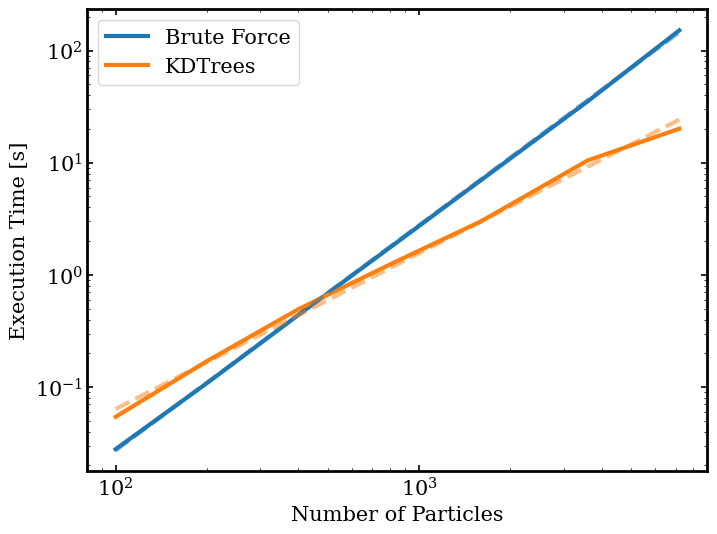

In [13]:
pl.figure(figsize=(8,6))
pl.loglog(ns, brute_times, label="Brute Force")
pl.loglog(ns, tree_times, label="KDTrees")

pl.plot(ns, np.exp(bfit[1])*ns**bfit[0],c="C0",ls="--",alpha=0.5)
pl.plot(ns, np.exp(tfit[1])*ns**tfit[0],c="C1",ls="--",alpha=0.5)

pl.ylabel("Execution Time [s]")
pl.xlabel("Number of Particles")

pl.legend()
pl.show()


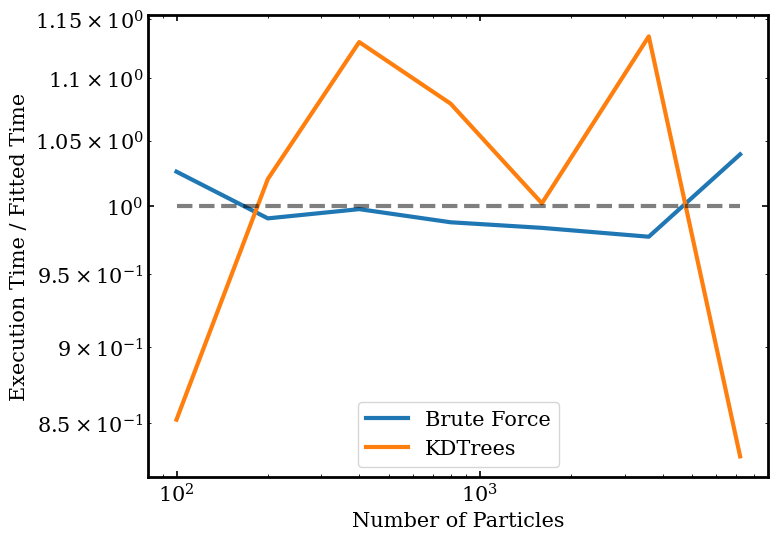

In [15]:
pl.figure(figsize=(8,6))
pl.loglog(ns, brute_times / (np.exp(bfit[1])*ns**bfit[0]), label="Brute Force")
pl.loglog(ns, tree_times / (np.exp(tfit[1])*ns**tfit[0]), label="KDTrees")

pl.plot(ns, np.ones(len(ns)),c="k",ls="--",alpha=0.5)

pl.ylabel("Execution Time / Fitted Time")
pl.xlabel("Number of Particles")

pl.legend()
pl.show()

The above plot shows the scaling of the 2 methods for computing the accleration. The brute force approach scales almost exactly as $O(n^2)$, as expected. The KDTree method scales better, with a powerlaw fit giving a scaling of $\sim O(n^{1.4})$. But the fit is clearly not sufficient as the actual result clearly curves about the fit. This is likely a reflection of the $O(n\log{n})$ scaling of the algorithm.

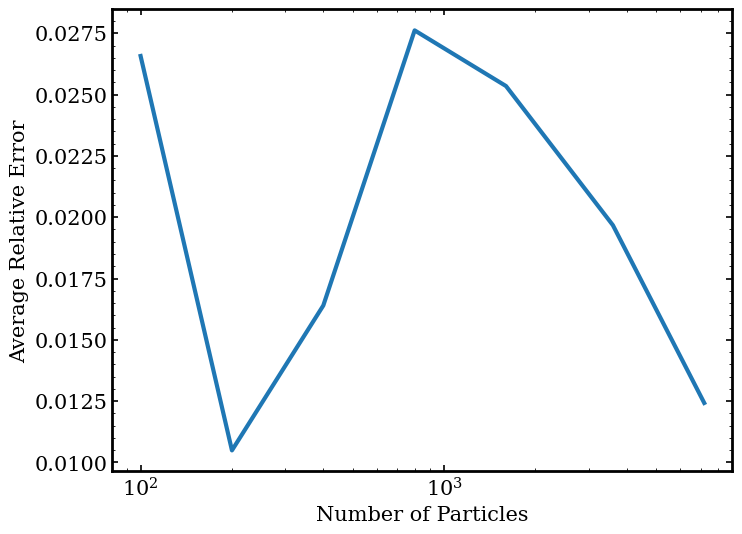

In [16]:
pl.figure(figsize=(8,6))
pl.semilogx(ns, np.abs(avg_err))

pl.ylabel("Average Relative Error")
pl.xlabel("Number of Particles")

pl.show()

The above plot shows how the error between the KDTree method and brute force method scales with the number of particles. The KDTree method with a tolerance of 0.5 remains in the realm of ~2% error across the range of particle numbers I tried.

# Problem 2

In [187]:
from pyro import Pyro

In [196]:
solver = "compressible"
problem_name = "kh"
param_file = "inputs.kh"
pyro_sim1 = Pyro(solver)
pyro_sim1.initialize_problem(problem_name, inputs_file=param_file)
pyro_sim1.run_sim()

In [197]:
solver = "compressible_rk"
problem_name = "kh"
param_file = "inputs.kh"
pyro_sim2 = Pyro(solver)
pyro_sim2.initialize_problem(problem_name, inputs_file=param_file)
pyro_sim2.run_sim()

In [198]:
solver = "compressible_fv4"
problem_name = "kh"
param_file = "inputs.kh"
pyro_sim3 = Pyro(solver)
pyro_sim3.initialize_problem(problem_name, inputs_file=param_file)
pyro_sim3.run_sim()

In [199]:
solver = "compressible_sdc"
problem_name = "kh"
param_file = "inputs.kh"
pyro_sim4 = Pyro(solver)
pyro_sim4.initialize_problem(problem_name, inputs_file=param_file)
pyro_sim4.run_sim()

warning, key: compressible.limiter not defined


In [204]:
solver = "compressible"
problem_name = "kh"
param_file = "inputs.kh"
extra_parameters = {'kh.u_1':5, 'kh.u_1':-5}
pyro_sim5 = Pyro(solver)
pyro_sim5.initialize_problem(problem_name, inputs_file=param_file, inputs_dict=extra_parameters)
pyro_sim5.run_sim()

In [205]:
solver = "compressible_rk"
problem_name = "kh"
param_file = "inputs.kh"
extra_parameters = {'kh.u_1':5, 'kh.u_1':-5}
pyro_sim6 = Pyro(solver)
pyro_sim6.initialize_problem(problem_name, inputs_file=param_file, inputs_dict=extra_parameters)
pyro_sim6.run_sim()

In [206]:
solver = "compressible_fv4"
problem_name = "kh"
param_file = "inputs.kh"
extra_parameters = {'kh.u_1':5, 'kh.u_1':-5}
pyro_sim7 = Pyro(solver)
pyro_sim7.initialize_problem(problem_name, inputs_file=param_file, inputs_dict=extra_parameters)
pyro_sim7.run_sim()

In [207]:
solver = "compressible_sdc"
problem_name = "kh"
param_file = "inputs.kh"
extra_parameters = {'kh.u_1':5, 'kh.u_1':-5}
pyro_sim8 = Pyro(solver)
pyro_sim8.initialize_problem(problem_name, inputs_file=param_file, inputs_dict=extra_parameters)
pyro_sim8.run_sim()

warning, key: compressible.limiter not defined


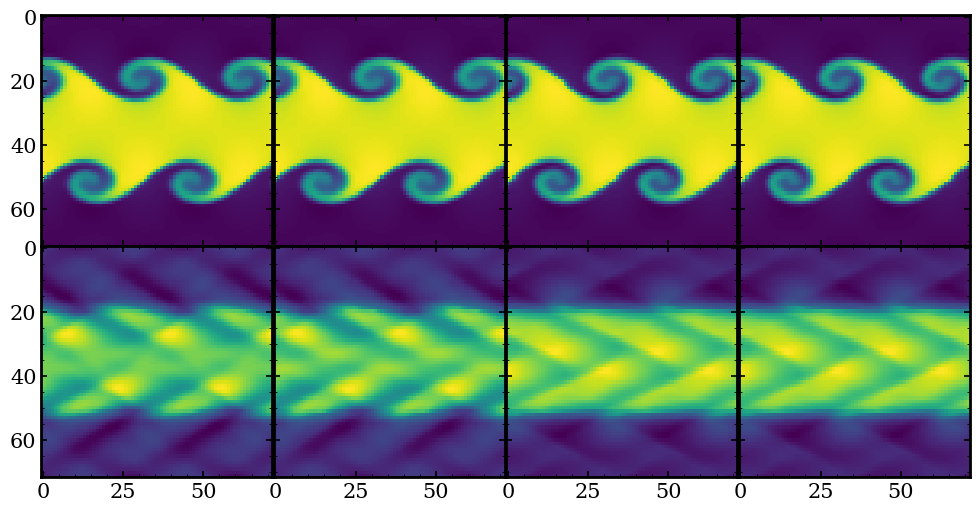

In [234]:
fig, ax = pl.subplots(2,4, figsize=(12,6), sharex=True, sharey=True, gridspec_kw = {'wspace':0, 'hspace':0})

ax[0,0].imshow(pyro_sim1.get_var("density").T)
ax[0,1].imshow(pyro_sim2.get_var("density").T)
ax[0,2].imshow(pyro_sim3.get_var("density").T)
ax[0,3].imshow(pyro_sim4.get_var("density").T)
ax[1,0].imshow(pyro_sim5.get_var("density").T)
ax[1,1].imshow(pyro_sim6.get_var("density").T)
ax[1,2].imshow(pyro_sim7.get_var("density").T)
ax[1,3].imshow(pyro_sim8.get_var("density").T)
pl.show()